# Scientific Computing Software Design Report



This report has four sections
1. Preparation 
2. Summary of the software
3. Key software design decisions made
4. Reflective learning log

## 1: Preparation

In this report, I will demonstrate my software with lots of examples. To make it clearer and nicer, I will put functions and packages in this section, then we will not need to import them every time.



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import matplotlib.animation as animation

def ode1(x,t):
    dxdt = x 
    return dxdt

def predator_prey(u,t0):
    x,y = u
    a = 1
    b = 0.2
    d = 0.1
    dxdt = x*(1-x)-(a*x*y)/(d+x)
    dydt = b*y*(1-y/x)
    return np.array([dxdt,dydt])

def algebraic_cubic(u):
    x,c = u
    return x**3 - x + c



## 2. Summary of the software

This part is a brief summary of my software. The software is designed to solve ODE(ordinary differential equations) and PDE(partial differential equations). There are several libraries built to complete this task.


### 2.1 ODE Solver

The ***ode_solver*** is a homemade library which is used to solve ODE. It is similar to odeint in scipy. For any dimension of ODEs, given intial values at time *t0*, the solver will output values of variables at time *tn* (which is user's input) using either euler's methods, 4th order Runge Kutta method and midpoint method. Also, the special thing of my ode solver is that, it gives all solutions for each timestep from *t0* to *tn*. There are three numerical integrators called *euler*, *RK4*, *midpoint* implementing one step of euler's method and 4th-order Runge-Kutta method and midpoint method respectively in the module, and a *solve_to* funcion to solve *x1,t1* to *x2,t2* in steps no bigger than *deltat_max* using one of numerical integrators.

To solve an ODE, first, we import ***ode_solver***, and use command ***ode_solver.solve_to(func, x1, t1, t2, method, deltat_max)***. Where *func* is the ODE function; *x1* is the initial values at start time; *t1* is the initial time; *t2* is the end time; *method* is either 'euler','RK4' or 'midpoint'; *delta_max* is the maximum timestep allowed. The reult will return a list, with solution at final time, and solutions between start time and final time, and t values at each step. Below we use our ode solver to solve ode1 and predator_prey 

The solution of ode1 at t = 1.0 is 2.7182410547639475


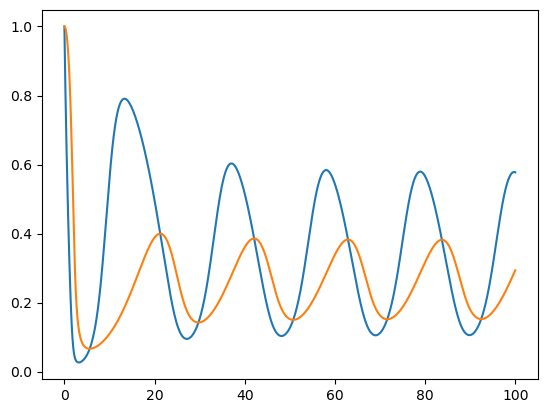

In [3]:
import ode_solver

# solve ode1 at t =1 
z1 = ode_solver.solve_to(ode1,1,0,1,'euler',0.0001)
print('The solution of ode1 at t = '+ str(z1[2][-1]) + ' is ' + str(z1[0]))
# solve predator prey between[0,100] and plot graph
z2 = ode_solver.solve_to(predator_prey,(1,1),0,100,'RK4',0.01)
plt.plot(z2[2], z2[1][0], z2[2], z2[1][1],label='RK4(deltat=0.01)')

### 2.2 Numerical Shooting

The ***shooting*** is a homemade library which is used to find a initial value of variables and a period that will generate limit cycles. *shooting_func* in the module is function implementing the equations(include phase conditions) in shooting method. *shooting_solve* is a function use *root* in scipy to solve equations in *shooting_func*. The result will return values of variables and a period. 

To do this task,first we import shooting module and simply call ***shooting.shooting_solve(func, guess)***, where *func* is your ode, *guess* is your guess of initial values and period. For example, we try shooting method on predator prey ode.

In [4]:
import shooting

z1 = shooting.shooting_solve(predator_prey,(1,1,1))
test = np.allclose(shooting.shooting_func(predator_prey,z1),0,1e-5) # test the result
print('The shooting solution of predator prey is',z1)
print(test)

The shooting solution of predator prey is [0.27015621 0.27015621 0.60750411]
True


### 2.3 Continuation

The ***continuation*** is a homemade library used to get the solutions depending on a parameter c. In this module, there are two functions for continuation. *natural* for natural parameter continuation and *psuedo_arclength* for psuedo arclength continuation.
Natural parameter continuation uses constant increment of c to generate solutions while psuedo arclength continuation involves an equation about c to solve c and solutions together.And they both use *root* in scipy to find roots, and return a list containing values of parameters and corresponding solutions.

To use continuations finding solutions, first we import ***continuation***, and call ***continuation.natual(func,rang,guess)*** to use natural parameter conituation,call ***continuation.psuedo_arclength(func, rang, guess)*** to use psuedo arclength continuation where *func* is the ode, *rang* is the range of parameter c and *guess* is your guess of solutions. Following is an example solving algebraic_cubic equation.


The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Converge fails at c =  0.3879999999999999
The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
Converge fails at c =  0.3879999999999999


Text(0, 0.5, 'Solution')

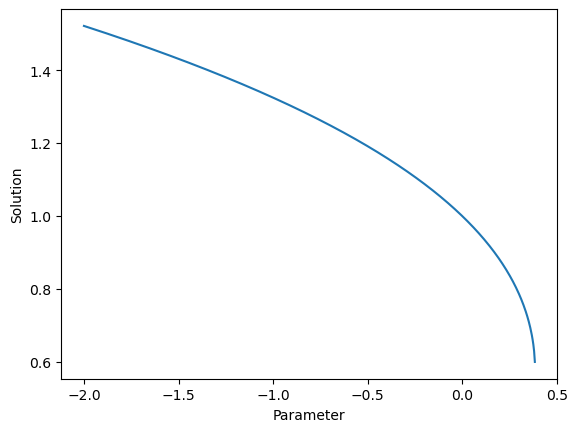

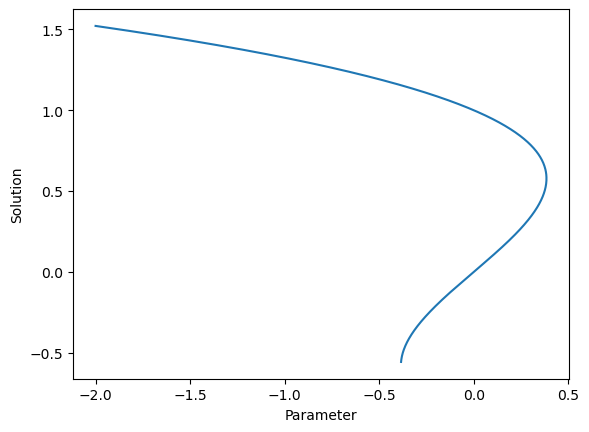

In [5]:
import continuation

#solve equation using natural continuation
z = continuation.natural(algebraic_cubic,(-2,2),2)
plt.plot(z[1],z[0])
plt.xlabel('Parameter')
plt.ylabel('Solution')
    
# solve using pseudo-arclength continuation
zz = continuation.psuedo_arclength(algebraic_cubic,(-2,2),2)
#print(zz[0])
plt.figure()
plt.plot(zz[1],zz[0])
plt.xlabel('Parameter')
plt.ylabel('Solution')

### 2.4 Finite Difference

The ***finite_difference*** is homemade library that is capable of finding numerical solutions to BVP ODEs using finite difference method. It involves using sparse matrix to solve the matrix-vector form of equation. And it can handle q term that depends on the spatial coordinate x. 

To use this module, first we import ***finite_difference***, then we simply call ***finite_difference.fd(a, b, alpha, beta, D, q)***, where a and b are boudaries, alpha and beta are solutions at boundaries, D is the parameter in ODE, and q is an extra term.The following shows an example.

True


C:\Users\YHU\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


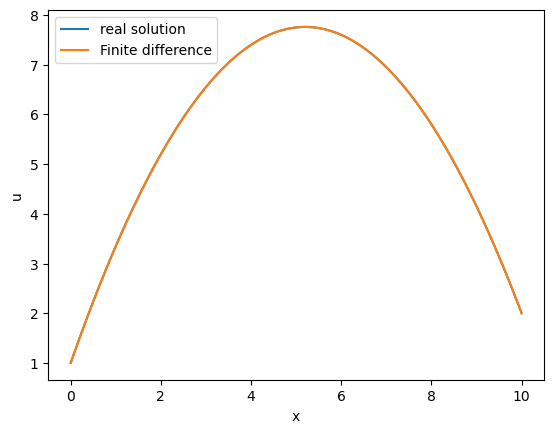

In [6]:
import finite_difference

q = lambda x: x*0 +1 # q[x] =1
    
z = finite_difference.fd(0,10,1,2,2,q = lambda x: x*0 +1)
    
# test the accuray, use finite difference, it equals real solution with an error tolerance 1e-3
def real_soln2(x):
    soln = (-1/(2*2))*(x-10)*(x-0)+((2-1)/(10-0))*(x-0)+1
    return soln
print(np.allclose(z[0],real_soln2(z[1]),1e-3))

plt.plot(z[1],real_soln2(z[1]),z[1],z[0])
plt.xlabel('x')
plt.ylabel('u')
plt.legend(['real solution','Finite difference'])

### 2.5 PDE Solver

The ***pde_solver*** is a homemade library which is used to solve PDEs. It consists of three functions corresponding to three methods: *explicit_euler* for explicit euler method, *implicit_euler* for implicit euler method, and *crank_nicolson* for Crank Nicolson method.
In *explicit_euler* method, user can also choose to use either euler or RK4 to solve the problem. For *implicit_euler* and *crank_nicolson* functions, sparse matrix is used to solve matrix-vector form of the equations.

To use functions mentioned above, we will need to import *pde_solver* first. Then, to use explicit euler method, call ***pde_solver. explicit_euler(a, b, alpha, beta, f, D, t, method)*** ; to use implicit euler, call ***pde_solver. implicit_euler(a, b, alpha, beta, f, D, t)*** ; to use Crank Nicolson method, call ***pde_solver.crank_nicolson(a, b, alpha, beta, f, D, t)***.  Where *a* and *b* are boudaries, *alpha* and *beta* are boundary conditions,*f* is the initial condition (which is a function you need to specify), *D* is the parameter of the diffusion term, and *t* is the time , *method* is either 'euler' or 'RK4'. Following are some exapmles.
 

[[0.         0.15643447 0.30901699 ... 0.30901699 0.15643447 0.        ]
 [0.         0.15527888 0.30673429 ... 0.30673429 0.15527888 0.        ]
 [0.         0.15413184 0.30446844 ... 0.30446844 0.15413184 0.        ]
 ...
 [0.         0.00113822 0.00224841 ... 0.00224841 0.00113822 0.        ]
 [0.         0.00112981 0.0022318  ... 0.0022318  0.00112981 0.        ]
 [0.         0.00112147 0.00221532 ... 0.00221532 0.00112147 0.        ]]


<IPython.core.display.Javascript object>


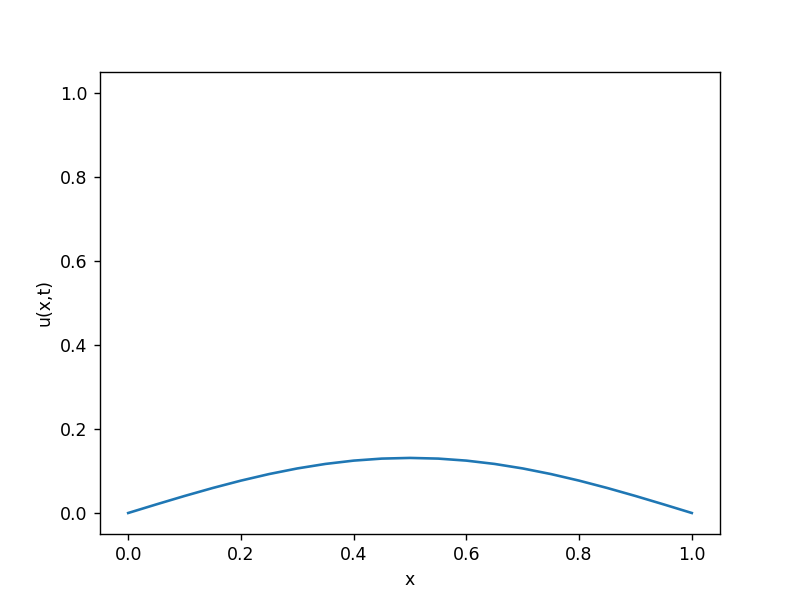

In [7]:
# implement explicit euler

import pde_solver

f = lambda x: np.sin(math.pi*(x-0)/(1-0))
#solve linear diffusion equation
Z= pde_solver.explicit_euler(0,1,0,0,f,0.5,1,'euler')    
print(Z[1])

%matplotlib notebook
fig,ax = plt.subplots()
ax.set_xlabel('x')
ax.set_ylabel('u(x,t)')

line, = ax.plot(Z[0],Z[1][0,:])

def animate(i):
    line.set_data((Z[0],Z[1][i,:]))
    return line
ani = animation.FuncAnimation(fig,animate,frames = int(Z[2]),blit =True,interval = 10)
plt.show()

<IPython.core.display.Javascript object>


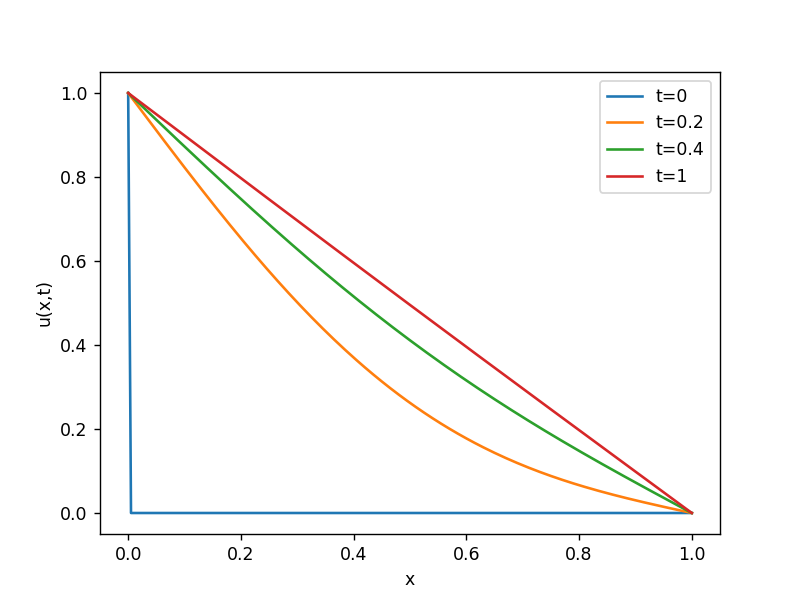

<IPython.core.display.Javascript object>


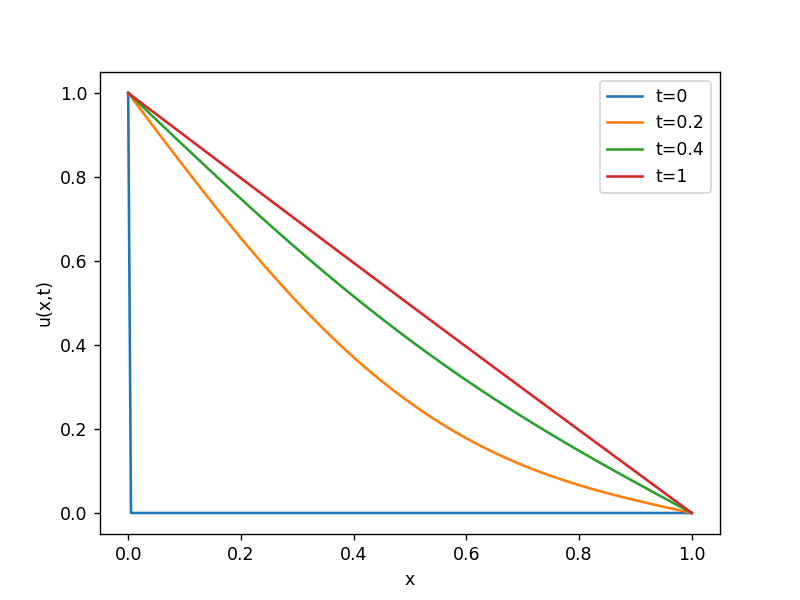

In [8]:
# implement implicit euler and crank nicolson methods
import pde_solver

# solve a PDE using implicit euler method
f = lambda x: 0*x + 0
z = pde_solver.implicit_euler(0,1,1,0,f,0.5,1)

plt.figure()
plt.plot(z[0],z[1][0],z[0],z[1][200],z[0],z[1][400],z[0],z[1][-1])
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend(['t=0','t=0.2','t=0.4','t=1'])
    
 # solve a PDE using crank nicolson method
f = lambda x: 0*x + 0
z = pde_solver.crank_nicolson(0,1,1,0,f,0.5,1)

plt.figure()
plt.plot(z[0],z[1][0],z[0],z[1][200],z[0],z[1][400],z[0],z[1][-1])
plt.xlabel('x')
plt.ylabel('u(x,t)')
plt.legend(['t=0','t=0.2','t=0.4','t=1'])


### 2.6 Test

***testscript*** is a homemade library which is used to test all the functions I implement. Functions that I tested includes continuation, finite difference, RK4, euler, midpoint, explicit euler, explicit euler(RK4), implicit euler, crank nicolson, and shooting .I used np.allclose to justify the results from my functions are very close to the true value with a certain tolerance allowed. Following I run the testscript, and the results are shown below.

In [9]:
import testscript

%run testscript.py

test_contiuation (__main__.TEST) ... ok
test_finite_difference (__main__.TEST) ... 

conitunation Pass:  True


C:\Users\YHU\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:214: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',
ok
test_ode_solver (__main__.TEST) ... 

finite_difference Pass:  True
RK4 Pass:  True
euler Pass:  True


ok
test_pde_solver (__main__.TEST) ... 

midpoint Pass:  True
explicit_euler Pass:  True
explicit_euler(RK4) Pass:  True
implicit_euler Pass:  True


ok
test_shooting (__main__.TEST) ... 

crank_nicolson Pass:  True
shooting Pass:  True


ok

----------------------------------------------------------------------
Ran 5 tests in 6.834s

OK


##  3 Key software design decisions

This section I will illustrate the software design decisions I made when I built modules and functions. 

### 3.1 ode_solver
When I built my ode_solver, I learnt that there are many numerical integrators to sovle ODE. For example, the simpliest and the most straightforward one is Euler's method. Also, there is another one which is called '4th-order Runge-Kutta(RK4)', which is similar to the method(RK45) used in scipy.odeint. To make my software better, I decided to use one extra method called 'midpoint'. Then I had three methods to implement, I built three functions:***'euler'***, ***'RK4'***, ***'midpoint'***  to implement **one step of each method**, this can make codes simple and easy to debug. I also modified my codes for each method so that the input initial values can be a vector so they **could cope with any dimension of ODEs**. For each method, we need a ode function(func), start time(t0), initial value at start time(u0), and timestep(deltat). These are user inputs. Because we only implemented one step, we don't have to specify end time. Then, to solve ODE at any time and use any one of our methods, I built ***solve_to***  function. I used **'for loop'** to iterate until I got solution I want.I also have 'deltat_max' to make sure timestep is always smaller than it. 

### 3.2 shooting
In shooting part, general idea is to **define a function that represent the shooting equations*** that will help me find the initial values which will give limit cycles, then **use root in scipy to find the solution**. To implement shooting on a second order ODE, first,  I defined a function called **shooting_equation**, in which I take into account three equations(as we have three unknowns:x,y,T): x(0)-x(T)= 0; y(0)-y(T)=0; dx/dt(0) =0. dx/dt(0) = 0 is fixing the pahse condition. We pass these three equations to the **shooting_solve** and got a solution.

### 3.3 continuation
There are two numerical conitunation methods in this library: natural parameter continuation and pseudo arclength continuation. So I wrote two functions for them. For the numerical continuation, I simply **add a constant increment to parameter c***, and **solve the corresponding equation using root in scipy**. However, this method is not stable because the root finding may not converge, so I use result.sucess to determine if root finder successfully gets a solution. And I turned to use another powerful method which is pseudo arclength conituation. This method solves c and solutions together, it also involves an extra equation, which I defined as **psuedo_equation**. The new u2 = (solution, c) needs to be solved using u1, u0 and scipy.root. Because I don't know the initial solutions of the equasion, I **use natural parameter continuation to get u0 and u1**, and run the iterations using psuedo arclength. To make sure there are at least two solutions, I put a if statement, if fails, the user has to choose another initail guess.

### 3.4 finite difference
Using finite difference, we can convert ode BVP into a system of algebraic equations. To do this, we normally can choose **for loop** to do this, however, considering the efficiency and simplicity, we choose to **use matrix-vector form to represent the system of eqautions**. Also, instead of using numpy to represent the matrix and numpy.linalg.solve to solve the problem, we used a much more efficient way. We **use sparse matrix in scipy library and scipy.sparse.linalg.spsolve()**. Becuase this is a much faster way, we can **increase number of steps N**, so it will still solve in a very short time and we get high accurate solutions.

### 3.5 pde solver
pde_solver consists of three methods to solve PDEs, which are explicit euler method, implicit euler method and crank nicolson method. For explicit euler method,  we **specified C =0.3(<0.5) to make the method stable** as it is only stable when C<0.5. We then used two **for loops**, the outside loop for time, inside loop for space. We also chose to use RK4 to solve PDE as RK4 has a higher accuracy. 

For implicit euler method, it is good that we don't have to restrict value of C, which means we can have any number of steps of space and time. We choose large values for them as this will increase the accuracy.We chose to **use sparse matrix and linalg.spsolve() in scipy to solve matrix-vector form of equations.**. This is because it is the most efficient way to do(better than np.solve and for loop).

Crank Nicolson method is a combination of explicit euler method and implicit euler method, and it has the highest accuracy. It has the similar codes as implicit euler method but the matrix vector form is different. 


### 3.6 overall software design
ode_solver is a powerful library to solve IVP and I made it to handle different dimensions of ODE. It can be used with other modules. For example, I implemented shooting method in shooting with ode_solver to solve to solutions at time T. 

psuedo arclength continuation is buildt based on the natural parameter continuation. Becuase natural parameter continuation is not a perfect method when encountered with saddle point(?). Also, we used first two solutions from natural continuation to run the psuedo arclenth method.

while ode_solver is to solve intial value problems(IVP), finite_difference is to solve boundary value problem (BVP).I also made my finite_ difference function can cope with q term. It is a powerful method which is used to solve BVP for both ODE and PDE.


pde_solver is containing three methods solving PDEs. crank_nicolson is built on the basis on explicit eule and implicit euler methods

                         
workflow: 

    mysoftware{continuation}             
        
        continuation{ODE,PDE}
        
          ODE{IVP,BVP}
             
             IVP{shooting}
               
                shooting ---ode_sover
              
             BVP -- finite_difference
            
           PDE--- explicit_euler/ implicit_euler/carnk_nicolson ---- finite_difference

## 4 Reflective learning log

I have learnt knowledge from this course from two perspectives: scientific computing,software engineering and what I will do differently

### 4. 1 Scientific computing outcomes
I have learnt a range of mathematical algorithms in this course. For solving ODEs, I leanrt the basic but powerful method: Euler's method, and another two high accurate methods: 4th-order Runge Kutta and midpoint method. I also compared the accuracy and run time of Euler's method and RK4 method, and found for a given accuray, euler's method needs deltat 10 times smaller than RK4 to achieve that. This tell me that RK4 is a better method than Euler's method and it has less computational cost. Also, for the run time, due to my labtop and function I tried, there is negligible difference between two methods(less than 0.001).I think I perfectly built my ode solver.

I also learnt shooting method, alothough I didn't achieve to solve the BVP, I used the method to find solutions of variables and period that can genrate limit cycle. After running my code, I found my code can find the equilibrium point of the ODE, which means when I put solutions back in the ode_solver, the plot of variables against time will have a horizontal line, which means any period is acceptable. This is not what I expected but it's mathematically correct. In the future, I will try to track solutions that are not at equilibrium point at also give limit cycles.I understand the shooting methods and can implemented equations in the code.

I found finite difference is a powerful method that can not only solve BVP but also convert a PDE into system of ODEs. For solving BVP and PDE, I can handle source term q if q is a constant or depends on x, however, for nonlinear term q(depends on u) I didn't able to solve them, this is what I will do in the future.

I learnt two methods for continuation, it is easy to understand the natural parameter continuation, I simply add a constant value to parameter c and solve accordingly. However, this method is not stable, solution may not converge. Thus, I used another mathod call'psuedo_arclength continuation.'This is a better method and I got nice plots using it. I understand the methods and algorithms,but I only implement psuedo for equations(e.g cubic equation), I didn't get it done for the ODE or PDE. This is because I can't find a proper function to use root to find solution whereas psuedo needs me to do that.

For three methods in pde_solver, I implement them smoothly. I first built explicit euler's method, we improve it to eliminate the restriction on C, then I got implicit method. To make higher accuracy, I implemented crank nicolson method, which is a combination of explicit and implicit euler's method. After testing, I found using same parameters, implicit and explicit method are correct to 2 and 3 decimal places while crank nicolson method is correct to 5 decimal places.

In this course, I also learnt useful methods, For example, code Profiling is a useful method to record the run time of my functions, and it will show details, it helps me to make my codes better. I used cProfile to find the run time of crank nicolson method and implicit method,and found that crank nicolson runs 1 time faster, compared 0.33 seconds with 0.65 seconds. 
Also, I learnt to use matrix vector form to represent equations instead of for loop, this is much neater and simpler. What is more, I learnt use sparse in scipy to solve matrix-vector form instead of using numpy, this is also a useful technique I have learnt.

Fro the testing ,I run a test script to prove my methods are correct. However, a good testscript should cover most of the lines of my codes, I only test results of my functions. In the future, I will extend tests to test more.

### 4.2 Software engineeing 

keep it simple: I try to keep my codes simple, for example, I built functions only implement one step of my euler's method,RK4 and midpoint method. This will easy to understand by others and easy to extend or debug

don't repeat yourself: I wrote functions to avoid this, so when I need them I just call the function instead of implementing the method again.

seperation of concerns: I seperated different modules: for example: ode_solver, pde_solver. So they don't overlap each other and when we need them, we just call seperate modules.

modularity and reusability: I made several module to implement different functionalities. It is not only to solve a particular  ode or pde, instead, users can solve wide range of functions depending on your input. 

documentation: I wrote clear explained docstings and comments, it will help user to input their parameters.

test: I wrote a testscript to test my functions. I use np.allclose( ) to justify the results of my function are correct to a certain level.In the future, I will extend my tests to to more testing and use results to improve my methods so that they will have higher accuracy

good use of git(version control): use github and git bash to update my code to github. This can help me store my code in repository and track my changes in codes.


### What will  I do differently
I will learn methods for every week seperately and then combine them all together. I will not focus on particular examples too much, but try to implement the functionalities so that they can deal with all the ODE and PDE. Contribute more on the continuation, such that it can work on ODE and PDE. Write testscript from the start. Make notes on my codes.
